# Leadangle_model.ipynb

プラズマシートのパラメータに対してリード角の変動をみる。

In [9]:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [10]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [11]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [12]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6     # MOON RADIUS [m]
OMG_E = 2.0478E-5     # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai_1 = 18            # 平均イオン原子量 (Bagenal+2015)
Ai_2 = 18            # 平均イオン原子量 (Bagenal+2015)
Ai_3 = 18            # 平均イオン原子量 (Bagenal+2015)

Ti_1 = 340           # 平均イオン温度 [eV] (Bagenal+2015)
Ti_2 = 88            # 平均イオン温度 [eV] (Bagenal+2015)
Ti_3 = 48            # 平均イオン温度 [eV] (Bagenal+2015)

Zi_1 = 1.4           # 平均イオン価数 [q] (Bagenal+2015)
Zi_2 = 1.4           # 平均イオン価数 [q](Bagenal+2015)
Zi_3 = 1.4           # 平均イオン価数 [q](Bagenal+2015)

rho0_1 = 800         # プラズマ質量密度 [amu cm-3] (Bagenal+2015)
rho0_2 = 2000        # プラズマ質量密度 [amu cm-3] (Bagenal+2015)
rho0_3 = 3600        # プラズマ質量密度 [amu cm-3] (Bagenal+2015)

rho0_1 = 1709        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_2 = 3539        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_3 = 4548        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_1 = 2050        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_2 = 4031        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_3 = 5458        # プラズマ質量密度 [amu cm-3] (by ME)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [13]:
# Plasma sheet scale height
Hp_1 = Hp0*math.sqrt(Ti_1/Ai_1)     # Scale height [m] (Bagenal&Delamere2011)
Hp_2 = Hp0*math.sqrt(Ti_2/Ai_2)     # Scale height [m] (Bagenal&Delamere2011)
Hp_3 = Hp0*math.sqrt(Ti_3/Ai_3)     # Scale height [m] (Bagenal&Delamere2011)
print('Scale height (1)', Hp_1/RJ, ' (2)', Hp_2/RJ, ' (3)', Hp_3/RJ)

Scale height (1) 2.7815263595531303  (2) 1.4150932438849708  (3) 1.0451156235874892


In [14]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 10))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta = 0.5*np.pi-S3lat
phi = 2*np.pi-S3wlon
B = np.zeros(phi.shape)
# Br = np.zeros(phi.shape)
# Btheta = np.zeros(phi.shape)
B_far = np.zeros(phi.shape)
B_close = np.zeros(phi.shape)
for i in range(phi.size):
    x = r_orbitM*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitM*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitM*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitM, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitC*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitC*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitC*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitC, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_close[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitF*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitF*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitF*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitF, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_far[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

In [15]:
# 衛星のトーラス内相対位置
# S3RH座標系の(x, y, z)座標
x0 = r_orbitM*np.cos(phi)
y0 = r_orbitM*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

# 遠心力座標系における緯度を計算する
theta_cent = np.arccos(rvec[2, :]/r_orbitM)     # 余緯度 [rad]
lat_cent = np.degrees(0.5*np.pi-theta_cent)     # 緯度 [deg]

In [16]:
# %% Rho, VA, and Lead angle (North)
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_1, Hp_1, 'N')      # 北向きの伝搬
    rho_1[i] = rho0_1*AMU*1E+6*np.exp(-(S0/Hp_1)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_L = np.degrees(OMGR*tau)

tau = np.zeros(S3wlon.size)
rho_2 = np.zeros(S3wlon.size)
VA_2 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_2, Hp_2, 'N')      # 北向きの伝搬
    rho_2[i] = rho0_2*AMU*1E+6*np.exp(-(S0/Hp_2)**2)
    VA_2[i] = B[i]/math.sqrt(MU0*rho_2[i])
leadangle_M = np.degrees(OMGR*tau)

tau = np.zeros(S3wlon.size)
rho_3 = np.zeros(S3wlon.size)
VA_3 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_3, Hp_3, 'N')      # 北向きの伝搬
    rho_3[i] = rho0_3*AMU*1E+6*np.exp(-(S0/Hp_3)**2)
    VA_3[i] = B[i]/math.sqrt(MU0*rho_3[i])
leadangle_H = np.degrees(OMGR*tau)

In [17]:
# Flux tube 質量密度分布
n_ft = 400
H1 = 10
H2 = 20
H3 = 30

z1 = np.zeros(n_ft)
z2 = np.zeros(n_ft)
z3 = np.zeros(n_ft)
maglat = np.linspace(0,np.pi/2,int(n_ft/2))     # 磁気緯度 [rad]
delmaglat = maglat[1]-maglat[0]
s = 0
for i in range(maglat.size-1):
    z1[i+maglat.size] = rho0_1*math.exp(-(s/Hp_1)**2)
    z1[-i+maglat.size] = rho0_1*math.exp(-(s/Hp_1)**2)
    z2[i+maglat.size] = rho0_2*math.exp(-(s/Hp_2)**2)
    z2[-i+maglat.size] = rho0_2*math.exp(-(s/Hp_2)**2)
    z3[i+maglat.size] = rho0_3*math.exp(-(s/Hp_3)**2)
    z3[-i+maglat.size] = rho0_3*math.exp(-(s/Hp_3)**2)
    dsdlam = r_orbitM*math.cos(maglat[i])*math.sqrt(1+3*math.sin(maglat[i])**2)
    s += dsdlam*delmaglat

fluxtube_arr = np.zeros((n_ft,49))
for i in range(3):
    fluxtube_arr[:,2+(15+2)*i] = z1
    fluxtube_arr[:,7+(15+2)*i] = z2
    fluxtube_arr[:,12+(15+2)*i] = z3
fluxtube_arr[:,15:15+2] = np.max(fluxtube_arr)
fluxtube_arr[:,30+2:30+2+2] = np.max(fluxtube_arr)

In [18]:
# HST data
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

hem = 'North'

north_doy14 = ['14/006_v06', '14/013_v13', '14/016_v12']
north_doy22 = ['22/271_v18', '22/274_v17']
north_doy = north_doy14 + north_doy22
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 'N'
if hem == 'South':
    refnum = 'S'
satoval = np.recfromtxt('data/JRM33/satellite_foot_'+refnum+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

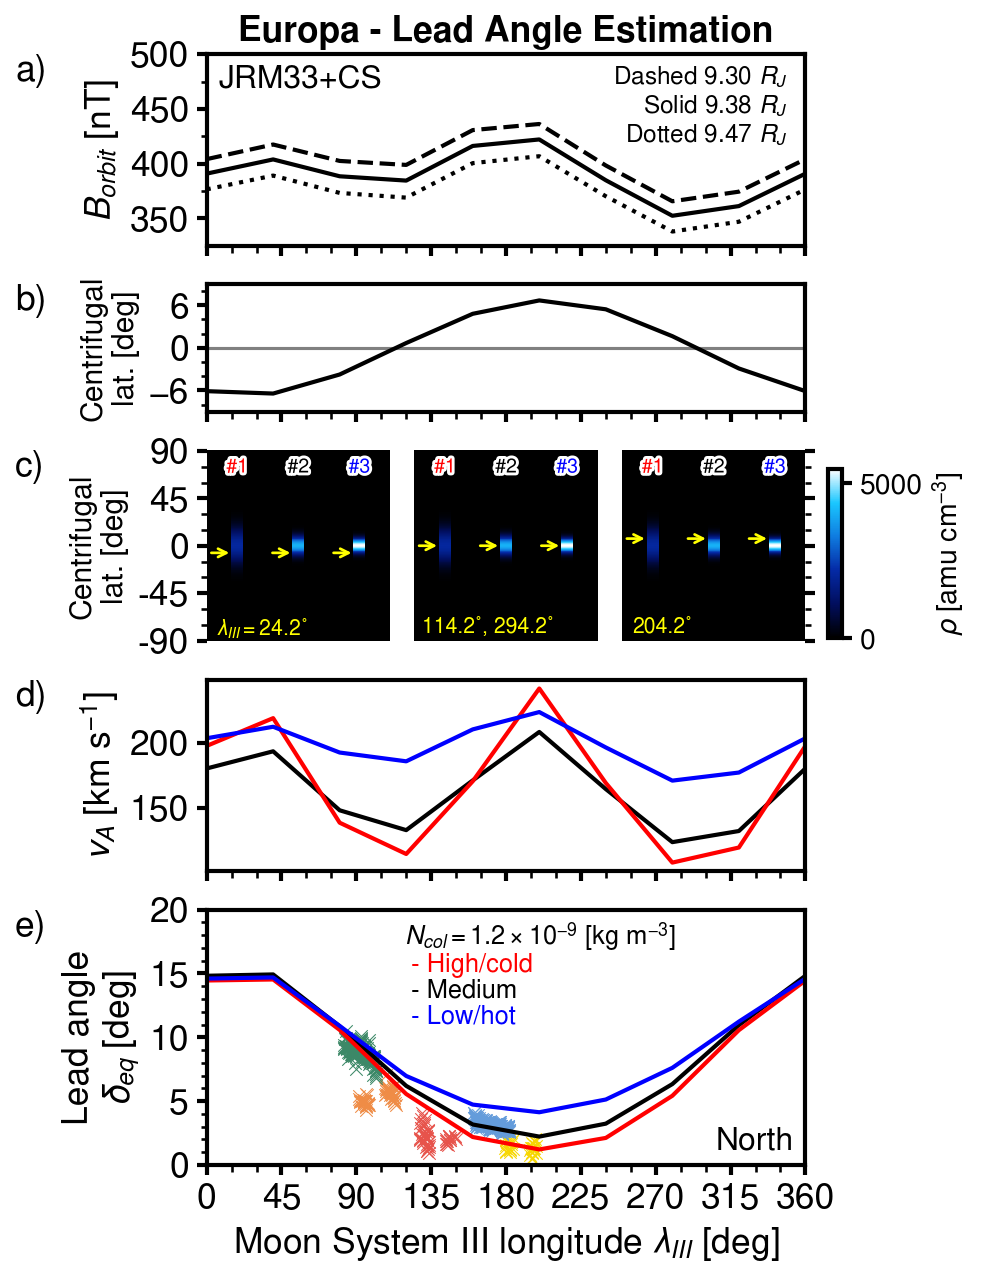

In [19]:
fsize = 17
fig, ax = plt.subplots(5, 1, figsize=(4.7, 8), dpi=150,
                       height_ratios=[3, 2, 3, 3, 4])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.32, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


ax[0].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)
ax[0].set_ylim(325, 500)
ax[0].set_ylabel('$B_{orbit}$ [nT]', fontsize=fsize)
ax[0].set_yticks(np.arange(350, 501, 50))
ax[0].set_yticklabels(np.arange(350, 501, 50))
ax[0].plot(np.degrees(S3wlon), B*(1E+9),
           linestyle='solid', linewidth=2, color='k')
ax[0].plot(np.degrees(S3wlon), B_close*(1E+9),
           linestyle='dashed', linewidth=2, color='k')
ax[0].plot(np.degrees(S3wlon), B_far*(1E+9),
           linestyle='dotted', linewidth=2, color='k')
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax[0].text(0.02, 0.95, 'JRM33+CS', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.9)
ax[0].text(0.97, 0.95,
           'Dashed 9.30 $R_J$\nSolid 9.38 $R_J$\nDotted 9.47 $R_J$',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.69)

ax[1].set_ylim(-9.0, 9.0)
ax[1].set_ylabel('Centrifugal\nlat. [deg]', fontsize=fsize*0.85)
ax[1].set_yticks(np.arange(-6, 7, 6))
# ax[1].set_yticklabels(np.arange(-2, 3, 1))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].plot(np.degrees(S3wlon), lat_cent, linewidth=2, color='k')
ax[1].axhline(y=0, color='gray', linestyle='solid', zorder=0.5)


"""
ax[2].set_ylabel('$\\rho$\n[amu cm$^{-3}$]', fontsize=fsize)
ax[2].set_yscale('log')
ax[2].plot(np.degrees(S3wlon), rho_1/(1E+6)/AMU, linewidth=2, color='b')
ax[2].plot(np.degrees(S3wlon), rho_2/(1E+6)/AMU, linewidth=2, color='k')
ax[2].plot(np.degrees(S3wlon), rho_3/(1E+6)/AMU, linewidth=2, color='r')
ax[2].text(0.01, 0.95, '(c)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize)
"""

ax[2].set_xlim(0,fluxtube_arr.shape[1])
ax[2].set_ylabel('Centrifugal\nlat. [deg]', fontsize=fsize*0.85)
ax[2].tick_params(axis='both', labelsize=fsize)
ax2 = ax[2].twinx()     # 右側にもy軸を設定する
ax[2].set_yticks(np.linspace(2, n_ft-2, 5))
ax[2].set_yticklabels(np.linspace(-90, 90, 5, dtype=int))
ax2.set_yticks(np.linspace(2, n_ft-2, 5)/n_ft)
ax2.set_yticklabels(np.linspace(-90, 90, 5, dtype=int))
ax[2].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax2.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[2].tick_params('x', length=0, which='major')  # 目盛りを消す
ax[2].tick_params('x', length=0, which='minor')  # 目盛りを消す
plt.setp(ax[2].get_xticklabels(), visible=False)  # ラベルを消す
plt.setp(ax2.get_yticklabels(), visible=False)  # ラベルを消す

location = ['right','top','bottom','left']
for loc in location:
    ax[2].spines[loc].set_visible(False)    # 枠線を消す
    ax2.spines[loc].set_visible(False)      # 枠線を消す

sm = ax[2].pcolormesh(fluxtube_arr, cmap=whiteblue)
axpos = ax[2].get_position()
cax = fig.add_axes([0.98, axpos.y0, 0.02, axpos.y1-axpos.y0])
pp = fig.colorbar(sm, cax=cax)
pp.set_label('$\\rho$ [amu cm$^{-3}$]', fontsize=fsize*0.8)   # フラックス
pp.ax.tick_params(labelsize=fsize*0.8)
pp.ax.yaxis.get_offset_text().set_fontsize(13)  # 指数部のフォントサイズ

# 矢印
for i in range(3):
    for j in range(3):
        anX = 2.2+17*j+5*i
        anY = n_ft/2+(-6.7+6.7*j)*n_ft/180
        ax[2].annotate("", xy=(anX, anY), xytext=(anX-2.153, anY),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3', fc='white', lw=1.3, ec='yellow', clip_on=True))

# シナリオ番号
scenum = ['#1', '#2', '#3']
sceclr = ['r', 'k', 'b']
for i in range(3):
    for j in range(3):
        txt = ax[2].text(2.5+5*j+(15+2)*i, 82*n_ft/90, scenum[j],
                    size=fsize*0.55,
                    color=sceclr[j],
                    horizontalalignment='center',
                    verticalalignment='center',
                    path_effects=[pe.withStroke(linewidth=2.8, foreground='white')])

ax[2].text(0.015, 0.13, '$\\lambda_{III}=$24.2˚', color='yellow',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize*0.6,
           zorder=5)
ax[2].text(0.36, 0.13, '114.2˚, 294.2˚', color='yellow',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize*0.6,
           zorder=5)
ax[2].text(0.71, 0.13, '204.2˚', color='yellow',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize*0.6,
           zorder=5)


# ax[3].set_ylim(150, 600)
ax[3].set_ylabel('$v_A$ [km s$^{-1}$]', fontsize=fsize)
ax[3].set_yticks(np.arange(100, 601, 50))
ax[3].set_yticklabels(np.arange(100, 601, 50))
ax[3].plot(np.degrees(S3wlon), VA_2/1000,
           linestyle='solid', linewidth=2, color='k')
ax[3].plot(np.degrees(S3wlon), VA_3/1000,
           linestyle='solid', linewidth=2, color='r')
ax[3].plot(np.degrees(S3wlon), VA_1/1000,
           linestyle='solid', linewidth=2, color='b')


ax[4].set_ylim(0, 20)
ax[4].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[4].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[4].set_yticks(np.arange(0, 21, 5))
ax[4].set_yticklabels(np.arange(0, 21, 5))
ax[4].plot(np.degrees(S3wlon), leadangle_M,
           linestyle='solid', linewidth=2, color='k')
ax[4].plot(np.degrees(S3wlon), leadangle_H,
           linestyle='solid', linewidth=2, color='r')
ax[4].plot(np.degrees(S3wlon), leadangle_L,
           linestyle='solid', linewidth=2, color='b')
# HST data
for i in range(len(doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[4].scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)

ax[4].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[4].text(0.98, 0.15, 'North', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.9)
ax[4].text(0.33, 0.63, ' - Low/hot', color='b',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.73, ' - Medium', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.83, ' - High/cold', color='r',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.96, '$N_{col}=1.2\\times 10^{-9}$ [kg m$^{-3}$]', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
"""ax[4].text(0.3, 0.96, 'Scenarios by Bagenal+2015', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)"""
# fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)
plt.show()

# カイ二乗検定



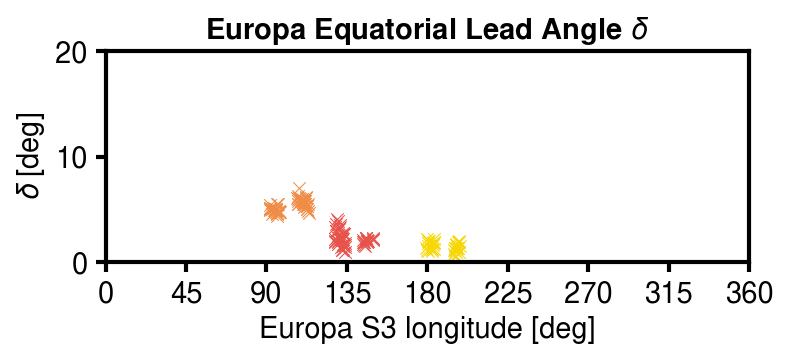

In [20]:
fontsize = 14
fig, ax = plt.subplots(figsize=(5,2), dpi=150)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)

plt.show()

In [21]:
rho0_1 = 1709        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_2 = 3539        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_3 = 4548        # プラズマ質量密度 [amu cm-3] (by ME)

Hp_1 = Hp0*math.sqrt(Ti_1/Ai_1)     # Scale height [m] (Bagenal&Delamere2011)
Hp_2 = Hp0*math.sqrt(Ti_2/Ai_2)     # Scale height [m] (Bagenal&Delamere2011)
Hp_3 = Hp0*math.sqrt(Ti_3/Ai_3)     # Scale height [m] (Bagenal&Delamere2011)
print('Scale height (1)', Hp_1/RJ, ' (2)', Hp_2/RJ, ' (3)', Hp_3/RJ)

Scale height (1) 2.7815263595531303  (2) 1.4150932438849708  (3) 1.0451156235874892


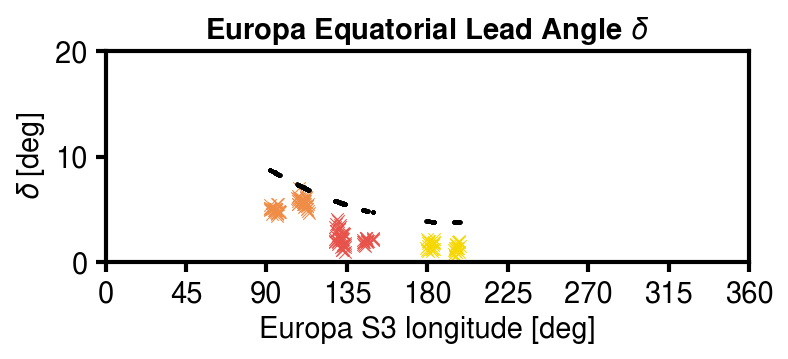

Low/hot
(3, 158)
218.65063881175246


0.00010943824919962238

In [22]:
# 2014年のデータ
from multiprocessing import Pool

def calc(moons3):
    """
    `moons3`: system iii longitude of the moon [deg]
    """

    S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons3))
    tau, _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                        math.radians(moons3),
                                        S0,
                                        rho0_1,
                                        Hp_1,
                                        'N') 
    return tau

img_len = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    img_len += moons30_arr.size

estimations = np.zeros((3,img_len))
NNN = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(moons30_arr.size)

    args = moons30_arr.tolist()
    with Pool(processes=10) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    estimations[0,NNN:NNN+moons30_arr.size] = moons30_arr      # moon s3 longitude [deg]
    estimations[1,NNN:NNN+moons30_arr.size] = eq_leadangle     # observed lead angle [deg]
    estimations[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]

    NNN += moons30_arr.size
    """
    for i in range(moons30_arr.size):
        S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons30_arr[i]))
        tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                                 math.radians(moons30_arr[i]),
                                                 S0,
                                                 rho0_1,
                                                 Hp_1,
                                                 'N')      # 北向きの伝搬
    leadangle_L = np.degrees(OMGR*tau)      # トータルで20分かかるよ"""
# print(estimations)

# PLOT
fontsize = 14
fig, ax = plt.subplots(figsize=(5,2), dpi=150)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(estimations[0,:], estimations[2,:], s=1, color='k', label=doy[i], zorder=2)
plt.show()

print('Low/hot')
print(estimations.shape)
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])
print(chi2)

from scipy import stats
stats.chi2.pdf(chi2, estimations.shape[1]-2)

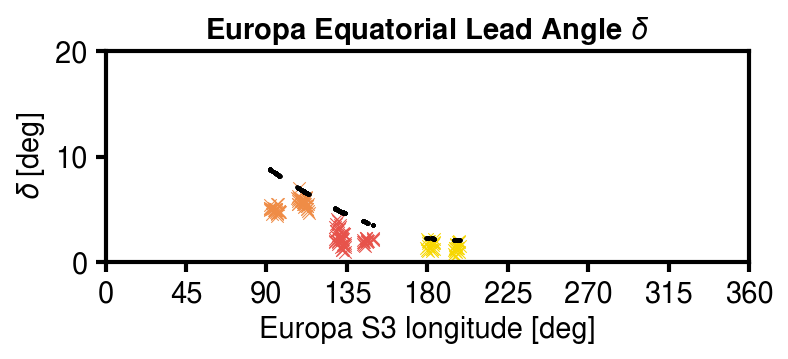

Medium
(3, 158)
132.29435984747562


0.009751499592951199

In [23]:
# 2014年のデータ
from multiprocessing import Pool

def calc(moons3):
    """
    `moons3`: system iii longitude of the moon [deg]
    """

    S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons3))
    tau, _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                        math.radians(moons3),
                                        S0,
                                        rho0_2,
                                        Hp_2,
                                        'N') 
    return tau

img_len = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    img_len += moons30_arr.size

estimations = np.zeros((3,img_len))
NNN = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(moons30_arr.size)

    args = moons30_arr.tolist()
    with Pool(processes=10) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    estimations[0,NNN:NNN+moons30_arr.size] = moons30_arr      # moon s3 longitude [deg]
    estimations[1,NNN:NNN+moons30_arr.size] = eq_leadangle     # observed lead angle [deg]
    estimations[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]

    NNN += moons30_arr.size
    """
    for i in range(moons30_arr.size):
        S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons30_arr[i]))
        tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                                 math.radians(moons30_arr[i]),
                                                 S0,
                                                 rho0_1,
                                                 Hp_1,
                                                 'N')      # 北向きの伝搬
    leadangle_L = np.degrees(OMGR*tau)      # トータルで20分かかるよ"""
# print(estimations)

# PLOT
fontsize = 14
fig, ax = plt.subplots(figsize=(5,2), dpi=150)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(estimations[0,:], estimations[2,:], s=1, color='k', label=doy[i], zorder=2)
plt.show()

print('Medium')
print(estimations.shape)
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])
print(chi2)

from scipy import stats
stats.chi2.pdf(chi2, estimations.shape[1]-2)

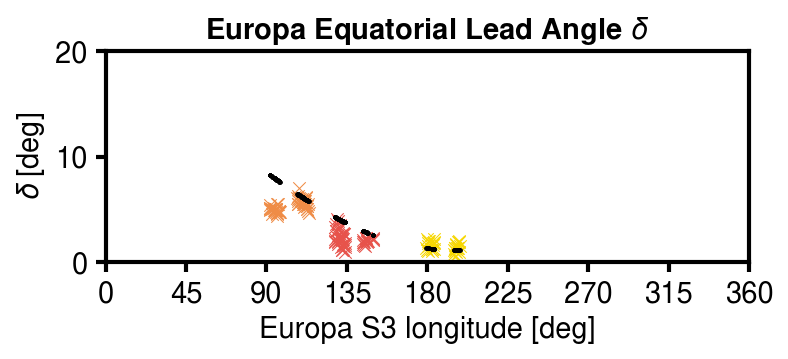

High/cold
(3, 158)
79.45981772431838


2.5979248018391137e-08

In [24]:
# 2014年のデータ
from multiprocessing import Pool

def calc(moons3):
    """
    `moons3`: system iii longitude of the moon [deg]
    """

    S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons3))
    tau, _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                        math.radians(moons3),
                                        S0,
                                        rho0_3,
                                        Hp_3,
                                        'N') 
    return tau

img_len = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    img_len += moons30_arr.size

estimations = np.zeros((3,img_len))
NNN = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(moons30_arr.size)

    args = moons30_arr.tolist()
    with Pool(processes=10) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    estimations[0,NNN:NNN+moons30_arr.size] = moons30_arr      # moon s3 longitude [deg]
    estimations[1,NNN:NNN+moons30_arr.size] = eq_leadangle     # observed lead angle [deg]
    estimations[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]

    NNN += moons30_arr.size
    """
    for i in range(moons30_arr.size):
        S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons30_arr[i]))
        tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                                 math.radians(moons30_arr[i]),
                                                 S0,
                                                 rho0_1,
                                                 Hp_1,
                                                 'N')      # 北向きの伝搬
    leadangle_L = np.degrees(OMGR*tau)      # トータルで20分かかるよ"""
# print(estimations)

# PLOT
fontsize = 14
fig, ax = plt.subplots(figsize=(5,2), dpi=150)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(estimations[0,:], estimations[2,:], s=1, color='k', label=doy[i], zorder=2)
plt.show()

print('High/cold')
print(estimations.shape)
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])
print(chi2)

from scipy import stats
stats.chi2.pdf(chi2, estimations.shape[1]-2)

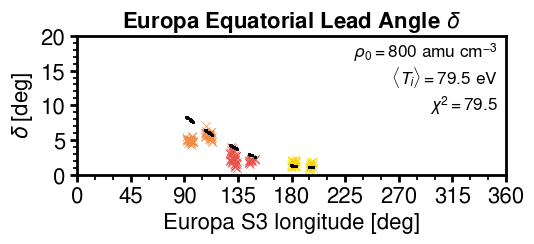

In [25]:
# PLOT
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])

fontsize = 16
fig, ax = plt.subplots(figsize=(5,2), dpi=100)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 21, 5))
ax.set_yticklabels(np.arange(0, 21, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    # ax.scatter(estimations[0,:], estimations[1,:], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(estimations[0,:], estimations[2,:], s=1, color='k', label=doy[i], zorder=2)
ax.text(0.98, 0.96, '$\\rho_{\,0}=$'+str(round(800,1))+' amu cm$^{-3}$', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.79, '$\\langle T_i \\rangle=$'+str(round(chi2,1))+' eV', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.58, '$\\chi^2=$'+str(round(chi2,1)), color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
plt.show()

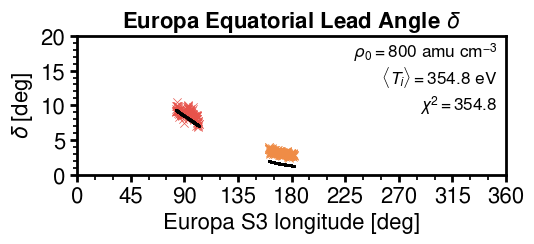

In [26]:
# 2022年のデータ
from multiprocessing import Pool

def calc(moons3):
    """
    `moons3`: system iii longitude of the moon [deg]
    """

    S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons3))
    tau, _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                        math.radians(moons3),
                                        S0,
                                        rho0_3,
                                        Hp_3,
                                        'N') 
    return tau

img_len = 0
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    img_len += moons30_arr.size

estimations = np.zeros((3,img_len))
NNN = 0
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(moons30_arr.size)

    args = moons30_arr.tolist()
    with Pool(processes=10) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    estimations[0,NNN:NNN+moons30_arr.size] = moons30_arr      # moon s3 longitude [deg]
    estimations[1,NNN:NNN+moons30_arr.size] = eq_leadangle     # observed lead angle [deg]
    estimations[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]

    NNN += moons30_arr.size


# PLOT
# print(((estimations[1,:]-estimations[2,:])**2))
# print(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])

fontsize = 16
fig, ax = plt.subplots(figsize=(5,2), dpi=100)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 21, 5))
ax.set_yticklabels(np.arange(0, 21, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    # ax.scatter(estimations[0,:], estimations[1,:], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(estimations[0,:], estimations[2,:], s=1, color='k', label=doy[i], zorder=2)
ax.text(0.98, 0.96, '$\\rho_{\,0}=$'+str(round(800,1))+' amu cm$^{-3}$', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.79, '$\\langle T_i \\rangle=$'+str(round(chi2,1))+' eV', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.58, '$\\chi^2=$'+str(round(chi2,1)), color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
plt.show()

In [27]:
print(estimations.shape)
chi2 = np.sum(((estimations[1,:]-estimations[2,:])**2)/estimations[2,:])
print(chi2)

(3, 367)
354.8120443961384


### 衛星のSystem III longitude - 2014

2014年: 127-134˚ & 143-150˚, 90-98˚ & 106-114˚, 178-184˚ & 193-199˚

2022年: 81-103˚

In [28]:
moons3long = estimations[0,:]
print('Total', moons3long.size)
range_0 = [127, 143, 90, 106, 178, 193]
range_1 = [134, 150, 98, 114, 184, 199]

for i in range(len(range_0)):
    print(np.where((moons3long>range_0[i])&(moons3long<range_1[i]))[0].size)

Total 367
0
0
55
0
35
0


Total 158 images in 2014

FIT_5

(1-1) 40 -> 8, 8, 8, 8, 8 (5個)

(1-2) 17 -> 8, 9 (2個)

(2-1) 29 -> 7, 7, 7, 8 (4個)

(2-2) 37 -> 7, 7, 7, 8, 8 (5個)

(3-1) 17 -> 8, 9 (2個)

(3-2) 18 -> 9, 9 (2個)

20個 までデータをまとめる。

FIT_6

(1-1) 40 -> 7, 7, 7, 7, 6, 6 (6個)

(1-2) 17 -> 6, 6, 5 (3個)

(2-1) 29 -> 6, 6, 6, 6, 5 (5個)

(2-2) 37 -> 6, 6, 6, 6, 6, 7 (6個)

(3-1) 17 -> 6, 6, 5 (3個)

(3-2) 18 -> 6, 6, 6 (3個)

26個 までデータをまとめる。

In [29]:
# 2014年のデータ
from multiprocessing import Pool

def calc(moons3):
    """
    `moons3`: system iii longitude of the moon [deg]
    """

    S0 = LeadA.Awave().tracefield(r_orbitM, math.radians(moons3))
    tau, _, _ = LeadA.Awave().tracefield2(r_orbitM,
                                        math.radians(moons3),
                                        S0,
                                        rho0_3,
                                        Hp_3,
                                        'N') 
    return tau

# 2014
img_cut = [[8,8,8,8,8,8,9],[7,7,7,8,7,7,7,8,8],[8,9,9,9]]
cut_idx = [[0,8,16,24,32,40,48],[0,7,14,21,29,36,43,50,58],[0,8,17,26]]

img_cut = [[7,7,7,7,6,6,6,6,5],[6,6,6,6,5,6,6,6,6,6,7],[6,6,5,6,6,6]]
cut_idx = [[0,7,14,21,28,34,40,46,52],[0,6,12,18,24,29,35,41,47,53,59],[0,6,12,17,23,29]]
# FIT_5の値 chi2=56.2 からどれくらい変わるか？


In [33]:
ests = np.zeros((4,26))
NNN = 0
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    params_arr = np.zeros((3, len(cut_idx[i])))
    # print(params_arr.shape)
    for j in range(len(cut_idx[i])):
        moons30_arr = data_arr[0, cut_idx[i][j]:cut_idx[i][j]+img_cut[i][j]]
        eq_leadangle = data_arr[1, cut_idx[i][j]:cut_idx[i][j]+img_cut[i][j]]
        params_arr[0,j] = np.average(moons30_arr)       # 平均値 [deg]
        params_arr[1,j] = np.average(eq_leadangle)      # 平均値 [deg]
        params_arr[2,j] = np.std(eq_leadangle, ddof=1)  # 標準偏差 [deg]
        # print(np.average(eq_leadangle), np.std(eq_leadangle))
        # print(np.std(eq_leadangle, ddof=1))

    moons30_arr = params_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = params_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(moons30_arr.size)

    args = moons30_arr.tolist()
    with Pool(processes=12) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    ests[0,NNN:NNN+moons30_arr.size] = params_arr[0,:]  # moon s3 longitude [deg]
    ests[1,NNN:NNN+moons30_arr.size] = params_arr[1,:]  # observed lead angle [deg]
    ests[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]
    ests[3,NNN:NNN+moons30_arr.size] = params_arr[2,:]  # standard deviation [deg]

    NNN += moons30_arr.size

[0.65636164 0.95860711 0.7406345  0.52182624 0.63854384 0.69470321
 0.19826525 0.13420036 0.15780109 0.26018076 0.08714708 0.0860926
 0.5136431  0.05065768 0.2945117  0.48151806 0.14519553 0.23339141
 0.36364669 0.27657002 0.45129544 0.38554621 0.33663624 0.29631699
 0.44715322 0.38958733]


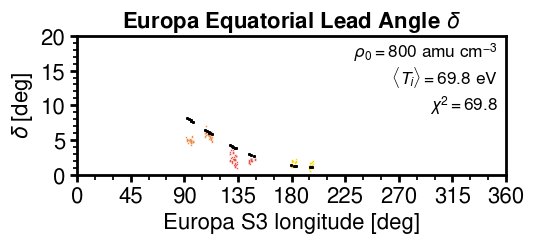

In [34]:
print(ests[3,:])
# PLOT
chi2 = np.sum(((ests[1,:]-ests[2,:])/ests[3,:])**2)
chi2 = np.sum(((ests[1,:]-ests[2,:])/0.974383)**2)

fontsize = 16
fig, ax = plt.subplots(figsize=(5,2), dpi=100)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 21, 5))
ax.set_yticklabels(np.arange(0, 21, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], s=1, linewidths=0.4, label=doy[i], zorder=1)
    # ax.scatter(estimations[0,:], estimations[1,:], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(ests[0,:], ests[2,:], s=1, color='k', label=doy[i], zorder=2)
ax.text(0.98, 0.96, '$\\rho_{\,0}=$'+str(round(800,1))+' amu cm$^{-3}$', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.79, '$\\langle T_i \\rangle=$'+str(round(chi2,1))+' eV', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.58, '$\\chi^2=$'+str(round(chi2,1)), color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
plt.show()    

In [35]:
print(ests[3,:])

[0.65636164 0.95860711 0.7406345  0.52182624 0.63854384 0.69470321
 0.19826525 0.13420036 0.15780109 0.26018076 0.08714708 0.0860926
 0.5136431  0.05065768 0.2945117  0.48151806 0.14519553 0.23339141
 0.36364669 0.27657002 0.45129544 0.38554621 0.33663624 0.29631699
 0.44715322 0.38958733]


In [36]:
print(chi2)

69.78622200156217


### 衛星のSystem III longitude - 2022

2014年: 127-134˚ & 143-150˚, 90-98˚ & 106-114˚, 178-184˚ & 193-199˚

2022年: 81-103˚, 159-182˚

In [37]:
img_len = 0
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    img_len += moons30_arr.size
    # print(moons30_arr)
    print(moons30_arr.size)

149
218


In [38]:
moons3long = estimations[0,:]
print('Total', moons3long.size)
range_0 = [81, 159]
range_1 = [103, 182]

for i in range(len(range_0)):
    print(np.where((moons3long>range_0[i])&(moons3long<range_1[i]))[0].size)

Total 367
149
218


Total 367 images in 2022

(1) 149 -> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9 (15個)

(2) 218 -> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9 (22個)

37個 までデータをまとめる。

In [39]:
# 2022
img_cut = [[10,10,10,10,10,10,10,10,10,10,10,10,10,10,9],
           [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9]]
cut_idx = [[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],
           [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,209]]

In [40]:
ests = np.zeros((4,37))
NNN = 0
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    params_arr = np.zeros((3, len(cut_idx[i])))
    for j in range(len(cut_idx[i])):
        moons30_arr = data_arr[0, cut_idx[i][j]:cut_idx[i][j]+img_cut[i][j]]
        eq_leadangle = data_arr[1, cut_idx[i][j]:cut_idx[i][j]+img_cut[i][j]]
        params_arr[0,j] = np.average(moons30_arr)       # 平均値 [deg]
        params_arr[1,j] = np.average(eq_leadangle)      # 平均値 [deg]
        params_arr[2,j] = np.std(eq_leadangle, ddof=1)  # 標準偏差 [deg]
        print(eq_leadangle, np.average(eq_leadangle), np.std(eq_leadangle, ddof=1))
        # print(np.average(eq_leadangle), np.std(eq_leadangle))

    moons30_arr = params_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = params_arr[1,:]   # observed lead angle [deg]
    tau = np.zeros(params_arr[0,:].size)

    args = params_arr[0,:].tolist()
    with Pool(processes=10) as pool:
        result_list = list(pool.map(calc, args))
    tau = np.array(result_list)         # [sec]
    leadangle_est = np.degrees(OMGR*tau)  # [deg]
    
    ests[0,NNN:NNN+moons30_arr.size] = params_arr[0,:]  # moon s3 longitude [deg]
    ests[1,NNN:NNN+moons30_arr.size] = params_arr[1,:]  # observed lead angle [deg]
    ests[2,NNN:NNN+moons30_arr.size] = leadangle_est    # estimated lead angle [deg]
    ests[3,NNN:NNN+moons30_arr.size] = params_arr[2,:]  # standard deviation [deg]

    NNN += moons30_arr.size

[ 9.3995636   9.24505335  9.0648196   9.17529879  9.91694442  9.89066191
 10.5160848   9.93025459  9.31123407  9.23312407] 9.56830392103856 0.46834293280283756
[9.2310359  9.27443653 9.11277009 9.18207533 9.23167338 9.20885925
 9.2633072  9.12726783 9.87762197 9.65903313] 9.3168080605328 0.2490550027764723
[9.77983785 8.88632938 8.29563823 9.12432368 8.80714468 9.30184575
 9.12835779 9.12202679 9.15902384 9.48399817] 9.108852615485679 0.3990786803130209
[8.91710079 9.21209164 8.86293731 9.09358893 8.96012868 8.69427022
 8.90914559 8.68719217 8.76552657 8.66812335] 8.877010525274018 0.18086818069042618
[8.78953206 8.53228143 9.18630069 8.60773454 8.8902357  8.92654918
 8.70671134 8.88773385 8.5789923  8.50384433] 8.760991541834692 0.21599130854806187
[8.72048543 8.81055432 9.22956127 8.73957698 9.03045466 8.0054542
 8.82959608 9.08308592 8.78991943 8.56613544] 8.780482373478465 0.33516473677284686
[7.50791019 8.67357489 8.72840564 8.98654479 9.45266573 9.26365025
 9.76297631 9.6899597  

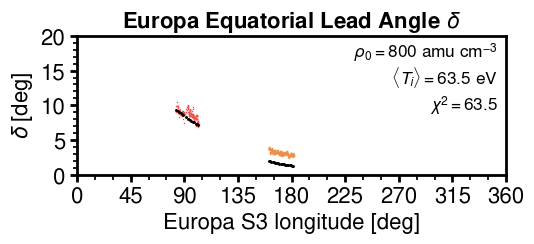

In [41]:
# PLOT
# chi2 = np.sum(((ests[1,:]-ests[2,:])/ests[3,:])**2)
chi2 = np.sum(((ests[1,:]-ests[2,:])/0.974383)**2)

fontsize = 16
fig, ax = plt.subplots(figsize=(5,2), dpi=100)
fig.tight_layout()
ax.set_title('Europa Equatorial Lead Angle $\\delta$', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(0,20)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 21, 5))
ax.set_yticklabels(np.arange(0, 21, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # observed lead angle [deg]
    ax.scatter(moons30_arr, eq_leadangle, marker='x', c=cpalette[i], s=1, linewidths=0.4, label=doy[i], zorder=1)
    # ax.scatter(estimations[0,:], estimations[1,:], marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    ax.scatter(ests[0,:], ests[2,:], s=0.7, color='k', label=doy[i], zorder=2)
ax.text(0.98, 0.96, '$\\rho_{\,0}=$'+str(round(800,1))+' amu cm$^{-3}$', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.79, '$\\langle T_i \\rangle=$'+str(round(chi2,1))+' eV', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
ax.text(0.98, 0.58, '$\\chi^2=$'+str(round(chi2,1)), color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fsize*0.73)
plt.show()    

In [42]:
print(ests[0,:])
print(ests[1,:])

[ 83.26261209  84.38179895  85.51875804  86.79784538  88.00587918
  89.16950751  91.68332121  93.44211453  94.63241583  95.7783067
  96.94196635  97.99903353  99.42918596 100.53955423 101.64104045
 161.13190604 162.14487302 163.13118243 164.17080523 165.13045641
 166.0723355  166.99644246 167.88500589 168.7735682  169.80429879
 170.72840036 171.68804215 172.68322378 173.57177628 174.46032615
 175.34887314 176.27295862 177.21481125 178.44987538 179.57830913
 180.63565409 181.43532238]
[9.56830392 9.31680806 9.10885262 8.87701053 8.76099154 8.78048237
 9.15645632 9.19154606 8.93447983 8.68217836 8.45911081 8.50458908
 8.18506456 8.00634999 7.32651119 3.78777252 3.33039417 3.5821254
 3.27117398 3.28921913 3.23710714 3.20730205 3.35969684 3.18433117
 2.97482501 3.15227586 3.0726476  2.92310613 2.99958751 3.10907625
 3.0846145  3.15549263 2.74256485 2.74648126 2.95657025 2.81764831
 2.85179617]


In [43]:
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
OMG_E = 2.0478E-5     # 衛星の公転角速度 [rad/s]
OMGR = OMGJ-OMG_E

tau = 1000
print(np.degrees(OMGR*tau))
print(np.degrees(OMGR)*tau)

8.903191178537863
8.903191178537863
